# Toward Optimal Retrieval: Dynamic Document Retreival in Vector-Based Search

#### By Yarin Shitrit
#### M.Sc Computer Science, Reichman University 2025

## 📚 Introduction to Retrieval-Augmented Generation (RAG)

### What is RAG?

#### **Retrieval-Augmented Generation (RAG)** is a hybrid architecture that combines the strengths of **retrieval-based** systems and **generative language models**. Instead of relying solely on a language model's internal parameters to answer questions or generate content, RAG explicitly augments the generation process by retrieving relevant external knowledge.

#### The RAG architecture was introduced to address limitations in traditional language models, especially their tendency to **"hallucinate"** or produce incorrect information due to lack of grounding in external knowledge sources.

---

### 🔍 Why Use RAG?

#### Pre-trained language models (e.g., GPT, LLaMA, etc.) are trained on massive datasets but are inherently static:

#### - They cannot learn new knowledge after training unless fine-tuned/retrained.
#### - Their knowledge is limited to their training cutoff.
#### - They might struggle with domain-specific or long queries.

### RAG solves these problems by:
#### - **Fetching real-time or up-to-date information** from external sources.
#### - **Reducing hallucinations** by basing responses on the retrieved context.
#### - **Improving performance** on specialized tasks or domains without retraining the model.

---

### 🧠 How Does RAG Work?

#### 1. **Encoder-based Retriever**
   #### - Given an input query, a retriever fetches the top-*k* most relevant documents from a vectorDB (e.g., FAISS, ChromaDB) using vector similarity search.
   #### - These documents serve as an external knowledge source.

#### 2. **Prompt Augmentation**
   #### - The retrieved documents are passed alongside the query into a language model (e.g., a transformer decoder) to generate a response.

#### 3. **Generator**
   #### - A generative model (like GPT or BART) produces the final output based on the augmented input (query + retrieved knowledge).

<div>
<img src="rag_workflow.png" width="500"/>
</div>

---


## Setup -  Lets create a simple RAG Agent

### 🔧 1. Install Dependencies

In [ ]:
!pip install langchain chromadb langchain-community langchain-openai tiktoken python-dotenv datasets ipywidgets rapidfuzz seaborn sentence-transformers tabulate

### 🔐 2. Set API Key

In [2]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Access the key
api_key = os.getenv("OPENAI_API_KEY")

# Set it as environment variable for OpenAI
os.environ["OPENAI_API_KEY"] = api_key

### 🗂️ 3. Define Vectorstore using ChromaDB

In [3]:
import os
import shutil
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")

def build_vectorstore(documents, persist_dir="./chroma_db", force_rebuild=False):
    """
    Builds or loads a persistent Chroma vectorstore using the given documents and OpenAI embedding model.

    Args:
        documents (list of Document): The documents to embed and store in the vectorstore.
        persist_dir (str): Path to the directory where the vectorstore will be stored.
                           Defaults to "./chroma_db".
        force_rebuild (bool): If True, deletes any existing vectorstore at the persist_dir
                              and rebuilds from scratch. Defaults to False.

    Returns:
        tuple:
            - Chroma: The initialized or loaded vectorstore object.
            - list of Document: The list of valid documents that were stored or loaded.

    Raises:
        ValueError: If no valid documents are provided when building a new vectorstore.

    """
    if os.path.exists(persist_dir) and not force_rebuild:
        print(f"🔁 Loading existing vectorstore from '{persist_dir}'...")
        vectorstore = Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
        stored = vectorstore._collection.get(include=["documents"])
        valid_docs = [Document(page_content=doc) for doc in stored["documents"]]
        print(f"✅ Loaded existing vectorstore with {len(valid_docs)} documents.")
        return vectorstore, valid_docs

    # Otherwise, rebuild the vectorstore
    print("📦 Building new Chroma vectorstore...")

    valid_docs = [doc for doc in documents if doc.page_content and doc.page_content.strip()]
    if not valid_docs:
        raise ValueError("❌ No valid documents found to build the vectorstore.")

    if os.path.exists(persist_dir):
        print(f"🧹 Removing old vectorstore at '{persist_dir}'...")
        shutil.rmtree(persist_dir)

    vectorstore = Chroma.from_documents(
        documents=valid_docs,
        embedding=embedding_model,
        persist_directory=persist_dir
    )

    print(f"✅ Vectorstore built and persisted with {len(valid_docs)} documents.")
    vectorstore.as_retriever()
    return vectorstore, valid_docs


### 🤖 4. Define the RAG Agent

In [59]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import Document
from typing import Dict, List

class CustomRAGAgent:
    """
    A Retrieval-Augmented Generation (RAG) agent that retrieves relevant documents
    from a vector store and uses a language model to generate answers based on those documents.

    Attributes:
        retriever: An object responsible for fetching the top-k most relevant documents 
                   given a query (e.g., a vectorstore retriever).
        llm:        A language model interface used to generate responses (e.g., ChatOpenAI).
        prompt:     A ChatPromptTemplate that formats system and user messages.
    """

    def __init__(self, retriever, llm, prompt):
        """
        Initialize the RAG agent.

        Args:
            retriever: A retriever instance with a `get_relevant_documents(question, k)` method.
            llm:       A language model instance with an `invoke(messages)` method.
            prompt:    A ChatPromptTemplate for formatting the system and user messages.
        """
        self.retriever = retriever
        self.llm = llm
        self.prompt = prompt

    def invoke(self, inputs: Dict[str, str], k: int) -> Dict[str, object]:
        """
        Run the RAG pipeline for a single query.

        Args:
            inputs: A dictionary containing:
                - "question" (str): The user’s query.
            k:       Number of top documents to retrieve.

        Returns:
            A dictionary with:
                - "answer" (str): The content of the LLM’s response.
                - "source_documents" (List[Document]): The retrieved Document objects.
                - "full_prompt" (str): The final prompt string sent to the LLM.
        """
        # Retrieve documents from vectorstore
        question = inputs["question"]
        docs: List[Document] = self.retriever.invoke(question, k=k) 
        documents = "\n\n".join(doc.page_content for doc in docs)

        # Format the prompt with the question and documents
        messages = self.prompt.format_messages(question=question, documents=documents)
        full_prompt_str = "\n\n".join(
            f"{msg.type.upper()}:\n{msg.content}\n" for msg in messages
        )

        # Get the LLM's response
        response = self.llm.invoke(messages)

        return {
            "answer": response.content,
            "source_documents": docs,
            "full_prompt": full_prompt_str
        }




## Recap - 🔥 Temperature in Large Language Models  

* **Definition:**
  A scalar $T > 0$ that scales logits before softmax:
  
  $$
  p_i(T) \;=\; \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}.
  $$
* **Effects:**

  * **Low $T < 1$:** Sharpens the distribution → more **deterministic** (greedy) outputs.
  * **High $T > 1$:** Flattens the distribution → more **random** (diverse) outputs.      
    
* **Why use it:**
  * **Balances** precision vs. creativity
  * **Mitigates** model overconfidence



In [60]:
def create_rag_agent(vectorstore):
    retriever = vectorstore.as_retriever()
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2, max_tokens=8000)

    system_template = (
        "You are a Useful agent. "
        "Answer only using the provided context below. "
        "Respond with concise. accurate answers. Use only 1-2 words in your answer.\n\n"
        "Context:\n{documents}"
    )

    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template("Question: {question}")
    ])

    return CustomRAGAgent(retriever, llm, prompt)


## 🍔 Example 🍕


### Build a custom vectorstore  

In [5]:
# Define custom documents
yarin_food = Document(page_content="Yarin's favorite food is Pizza", metadata={"id": 111111, "source": 3201})
michal_food = Document(page_content="Michal's favorite food is Croissant",metadata={"id": 111112, "source": 3202})

# Create a vectorstore
vectorstore, embeddings  = build_vectorstore(documents=[yarin_food, michal_food], persist_dir="./sample_db")


🔁 Loading existing vectorstore from './sample_db'...
✅ Loaded existing vectorstore with 2 documents.


### 🤖 Create a RAG agent

In [61]:
rag_agent = create_rag_agent(vectorstore)

#### Invoke the agent with fixed k = 1

In [62]:
result = rag_agent.invoke({"question": "what is Yarin's favortie food?"}, k=1)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------\n")
print(result["full_prompt"])

-------------Answer:-------------

Pizza

-------------Full prompt:-------------

SYSTEM:
You are a Useful agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Yarin's favorite food is Pizza


HUMAN:
Question: what is Yarin's favortie food?



### What about Michal's favorite food?

In [8]:
result = rag_agent.invoke({"question": "what is Michal's favortie food?"}, k=1)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------\n")
print(result["full_prompt"])

-------------Answer:-------------

Croissant

-------------Full prompt:-------------

SYSTEM:
You are a Useful agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Michal's favorite food is Croissant


HUMAN:
Question: what is Michal's favortie food?



### Can the RAG Agent can answer for both of us ? 

In [9]:
result = rag_agent.invoke({"question": "what are Yarin's and Michal's favortie food?"}, k=1)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------")
print(result["full_prompt"])

-------------Answer:-------------

Pizza

-------------Full prompt:-------------
SYSTEM:
You are a Useful agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Yarin's favorite food is Pizza


HUMAN:
Question: what are Yarin's and Michal's favortie food?



### Thats too bad...

### I guess k=1 is not the best option

### What about k=2 ?

In [58]:
result = rag_agent.invoke({"question": "what are Yarin's and Michal's favortie food?"}, k=2)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------")
print(result["full_prompt"])

-------------Answer:-------------

Pizza, Croissant

-------------Full prompt:-------------
SYSTEM:
You are a Useful agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Yarin's favorite food is Pizza

Michal's favorite food is Croissant


HUMAN:
Question: what are Yarin's and Michal's favortie food?



### Great! the agent managed to retrieve the 2 relevant documents about Yarin and Michal's favorite food
### But that requires us to know the number of documents needed before prompting the agent

# ❗ **Problem – Limitations of Fixed `k` in Document Retrieval**

### 🧠 Background

In Retrieval-Augmented Generation (RAG) and other retrieval-based systems, **vector similarity search** is a key operation. Given a query, the system retrieves the top-*k* most similar documents from a vector database using semantic embeddings and similarity metrics (e.g., cosine similarity or dot product).

The parameter **`k`** represents the number of documents to retrieve per query. In most RAG implementations, `k` is set to a **fixed value** (e.g., `k=3` or `k=5`) for all inputs.

While simple and easy to implement, **using a static value of `k` across all inputs introduces several problems** that can negatively impact retrieval relevance, model performance, and computational efficiency.

---

### 🔍 The Core Problem: One-Size-Does-Not-Fit-All

Different user queries or prompts have different levels of complexity, ambiguity, and knowledge requirements. However, a static `k` assumes that **every query benefits equally from the same number of retrieved documents** — which is often not true.

---

### 🔥 Why a Fixed `k` is Suboptimal

#### 1. **Under-retrieval (k too small)**
- Important context may be **missed**, especially for complex or vague queries.
- Language model generates **incomplete or hallucinated** responses due to lack of sufficient information.
- Example: A legal or medical question might require 10+ documents to cover relevant information.

#### 2. **Over-retrieval (k too large)**
- Irrelevant or noisy documents may dilute the useful context.
- More documents → longer input prompt → higher **token costs** in LLMs.
- More documents → more computing required, memory usage, and latency

#### 3. **No Adaptivity to Query Complexity**
- Not all queries are created equal:
  - Some are **simple and factoid-like** ("What is the capital of Italy?")
  - Others are **ambiguous, multi-faceted, or domain-specific**
- Fixed `k` ignores this variability, leading to suboptimal results in either direction.

---

### 🎯 Research Objective

The goal of this research is to **dynamically determine the optimal value of `k` per query**, based on characteristics of the input or the retrieval results — such as:

- Query entropy or uncertainty  
- Query length and type  
- Similarity score distribution of top retrieved documents
- Historical performance metrics  

By intelligently adjusting `k`, we aim to improve:

- Retrieval relevance and precision  
- LLM answer quality  
- Efficiency and cost-effectiveness of the system  

---

👉 In the next sections, we will explore strategies, algorithms, and evaluation methods for achieving this dynamic retrieval objective.


## 🧪 RAG Evaluation

### 🔍 Evaluation Setup
- **Corpus**: A general Q&A corpus (`HotPotQA`).
- **Model**: `gpt-4o-mini` used via LangChain's `ChatOpenAI`.
- **Retriever**: ChromaDB vectorstore with top-k document retrieval.

### 🧠 Accuracy Metric
- We use **cosine similarity**
- A prediction is considered correct if its cosine similarity score with the ground truth exceeds a given threshold (e.g. `>= 0.85`).

---


## Load a Test Dataset (HotpotQA)

In [92]:
from datasets import load_dataset

# Load HotpotQA dataset
hotpot = load_dataset("hotpot_qa", "fullwiki", trust_remote_code = True)
hotpot_qa_dataset = hotpot["validation"]

# Filter for short (1–2 word) answers
def is_short_answer(example):
    answer = example["answer"]
    return isinstance(answer, str) and 1 <= len(answer.strip().split()) <= 2

short_answer_dataset = hotpot_qa_dataset.filter(is_short_answer)
print(f"✅ Filtered dataset: {len(short_answer_dataset)} questions with 1–2 word answers.")

print("Dataset example: \n")
print(short_answer_dataset[0])

✅ Filtered dataset: 4702 questions with 1–2 word answers.
Dataset example: 

{'id': '5a8b57f25542995d1e6f1371', 'question': 'Were Scott Derrickson and Ed Wood of the same nationality?', 'answer': 'yes', 'type': 'comparison', 'level': 'hard', 'supporting_facts': {'title': ['Scott Derrickson', 'Ed Wood'], 'sent_id': [0, 0]}, 'context': {'title': ['Adam Collis', 'Ed Wood (film)', 'Tyler Bates', 'Doctor Strange (2016 film)', 'Hellraiser: Inferno', 'Sinister (film)', 'Deliver Us from Evil (2014 film)', 'Woodson, Arkansas', 'Conrad Brooks', 'The Exorcism of Emily Rose'], 'sentences': [['Adam Collis is an American filmmaker and actor.', ' He attended the Duke University from 1986 to 1990 and the University of California, Los Angeles from 2007 to 2010.', ' He also studied cinema at the University of Southern California from 1991 to 1997.', ' Collis first work was the assistant director for the Scott Derrickson\'s short "Love in the Ruins" (1995).', ' In 1998, he played "Crankshaft" in Eric Koy

## Create the documents from the dataset

In [12]:
from langchain_core.documents import Document

def create_documents(dataset):
    """
    Converts a structured dataset with titles and sentences into a list of unique LangChain Document objects.

    Args:
        dataset (list of dict): A dataset where each example contains:
            - 'context': a dictionary with keys:
                - 'title' (list of str): List of source titles.
                - 'sentences' (list of list of str): List of sentence lists, one per title.

    Returns:
        list of Document: A list of LangChain Document objects with 'page_content' as the text
        and 'metadata' containing the 'source' title. Duplicate passages are removed based on content and title.
    """
    docs = []
    seen_passages = set()

    for example in dataset:
        titles = example["context"]["title"]
        sentence_lists = example["context"]["sentences"]

        for title, sentences in zip(titles, sentence_lists):
            content = " ".join(sentences).strip()
            key = (title, content)
            if content and key not in seen_passages:
                doc = Document(
                    page_content=content,
                    metadata={"source": title}
                )
                docs.append(doc)
                seen_passages.add(key)

    return docs


Created 43507 documents.


In [ ]:
# Create the documents from the HotPotQA dataset
documents = create_documents(short_answer_dataset)
print(f"Created {len(documents)} documents.")

## Create the vectorstore from the documents

In [13]:
vectorstore, embedding = build_vectorstore(documents)

🔁 Loading existing vectorstore from './chroma_db'...
✅ Loaded existing vectorstore with 43509 documents.


In [14]:
def get_embedding(text: str) -> list[float]:
    """Get embedding"""
    response = embedding_model.embed_query(text)
    return response

def get_all_document_embeddings(vectorstore):
    collection = vectorstore._collection
    stored = collection.get(include=["embeddings", "documents"])

    # List of (id, embedding, document)
    embeddings = stored["embeddings"]  # List of [float]
    documents = stored["documents"]

    return embeddings, documents

hotpot_embeddings, hotpot_documents = get_all_document_embeddings(vectorstore)

## Define the evaluation workflow

In [15]:
import numpy as np
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_rag_agent_parallel(
    dataset,
    k: int = 3,
    n_questions: int = 10,
    threshold: float = 1.0,
    seed: int = 42,
    max_workers: int = 8,
    dynamic_k_function: callable = None,
    null_distribution=None,
    selected_indices= None,
    alpha: float = 0.05
):
    """
    Evaluate a RAG agent in parallel on a dataset using either fixed or dynamic-k retrieval.

    This function selects a subset of questions from the dataset and queries a RAG agent for answers,
    using a fixed `k` number of documents per question or dynamically determining `k` using statistical 
    methods (e.g., BH, Bonferroni, Higher Criticism).

    Args:
        dataset (dict): A dictionary with keys `"question"` and `"answer"` representing the QA dataset.
        k (int): Number of documents to retrieve when using fixed-k retrieval. Default is 3.
        n_questions (int): Number of questions to evaluate. Default is 10.
        threshold (float): Cosine similarity threshold to determine correctness. Default is 1.0.
        seed (int): Random seed for question selection. Default is 42.
        max_workers (int): Maximum number of threads for parallel execution. Default is 8.
        dynamic_k_function (callable): A function to determine `k` dynamically based on similarity scores and null distribution.
        null_distribution (list or np.ndarray): A precomputed null distribution of similarity scores for estimating p-values.
        selected_indices (list[int], optional): Predefined indices to select from dataset. If None, chosen randomly.
        alpha (float): Significance level for dynamic-k methods. Default is 0.05.

    Returns:
        dict: A dictionary with the following keys:
            - "n_questions": Number of questions evaluated
            - "accuracy": Accuracy score across evaluated questions
            - "evaluated": Count of evaluated questions (correct + incorrect)
            - "correct": Count of correct answers
            - "logs": List of detailed results per question
            - "seed": The random seed used
            - "selected_indices": Indices of the selected questions
            - "ks": List of `k` used per question
            - "retrieved_docs": Documents retrieved for the last evaluated question
    """
    total_available = len(dataset["question"])
    if selected_indices is None:
        indices = list(range(total_available))
        random.Random(seed).shuffle(indices)
        selected_indices = indices[:n_questions]


    questions = [dataset["question"][i] for i in selected_indices]
    answers = [dataset["answer"][i] for i in selected_indices]

    rag_agent = create_rag_agent(vectorstore)
    results = []
    correct = 0
    evaluated = 0
    all_ks = []

    if dynamic_k_function:
        print(f"\n🔍 Evaluating RAG Agent (with Dynamic k: {dynamic_k_function.__name__})\n")
    else:
        print(f"\n🔍 Evaluating RAG Agent (with fixed k={k})\n")


    def evaluate_single(idx, question, ground_truth):
        question_emb = get_embedding(question)

        if dynamic_k_function:
            sims = cosine_similarity([question_emb], hotpot_embeddings)[0]
            sorted_indices = np.argsort(sims)[::-1]
            doc_embs = [hotpot_embeddings[i] for i in sorted_indices]
            final_k = dynamic_k_function(question_emb, doc_embs, null_distribution, alpha)
        else:
            final_k = k

        all_ks.append(final_k)

        result = rag_agent.invoke({"question": question}, k=final_k)
        prediction = result["answer"]
        source_docs = result.get("source_documents", [])
        full_prompt = result.get("full_prompt")

        similar = cosine_similarity([get_embedding(prediction)], [get_embedding(ground_truth)])[0][0]

        return {
            "index": idx,
            "question": question,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "similar": similar,
            "status": "correct" if similar >= threshold else "incorrect",
            "k": final_k,
            "retrieved_docs": [
                {"source": doc.metadata.get("source", None), "content": doc.page_content} for doc in source_docs
            ],
            "full_prompt": full_prompt
        }

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(evaluate_single, idx, q, a)
            for idx, (q, a) in enumerate(zip(questions, answers))
        ]

        for future in tqdm(as_completed(futures), total=n_questions, desc="Evaluating"):
            log = future.result()
            results.append(log)
            if log["status"] == "correct":
                correct += 1
            if log["status"] in {"correct", "incorrect"}:
                evaluated += 1

    results.sort(key=lambda x: x["index"])

    for log in results:
        print(f"\n[{log['index']}] {'✅' if log['status'] == 'correct' else '❌'} {log['status'].upper()}")
        print(f"Question: {log['question']}")
        print(f"Prediction: {log['prediction']}")
        print(f"Ground Truth: {log['ground_truth']}")
        print(f"Similarity Score: {log['similar']:.4f}")
        print(f"k used: {log['k']} {'(Dynamic k)' if dynamic_k_function else '(Fixed k)'}")
        print(f"📨 Full Prompt:\n{log['full_prompt']}")
        print("-" * 60)

    accuracy = correct / evaluated if evaluated > 0 else 0.0

    print(f"\n🎯 Final Accuracy k = {k} on {evaluated} evaluated questions: {accuracy:.2%}")

    return {
        "n_questions": n_questions,
        "accuracy": accuracy,
        "evaluated": evaluated,
        "correct": correct,
        "logs": results,
        "seed": seed,
        "selected_indices": selected_indices,
        "ks": all_ks, 
        "retrieved_docs": log['retrieved_docs']
    }


## Lets test our RAG agent using fixed values of k (1,..,20)

In [ ]:
import time
seed = random.randint(0, 10_000_000)
n_questions = 100

# Shuffle once
total_available = len(short_answer_dataset["question"])
indices = list(range(total_available))
random.Random(seed).shuffle(indices)
selected_indices = indices[:n_questions]

# Run fixed-k evaluations
fixed_results = []
for k in range(1, 21):
    res = evaluate_rag_agent_parallel(
        dataset=short_answer_dataset,
        k=k,
        n_questions=n_questions,
        threshold=0.85,
        seed=seed,
        selected_indices=selected_indices,
        max_workers=10
    )
    res["used_k"] = k
    fixed_results.append(res)

    # Sleep to avoid TPM limit on OpenAI
    time.sleep(60)


## 📊  Plot the results

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_35911/2586886784.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


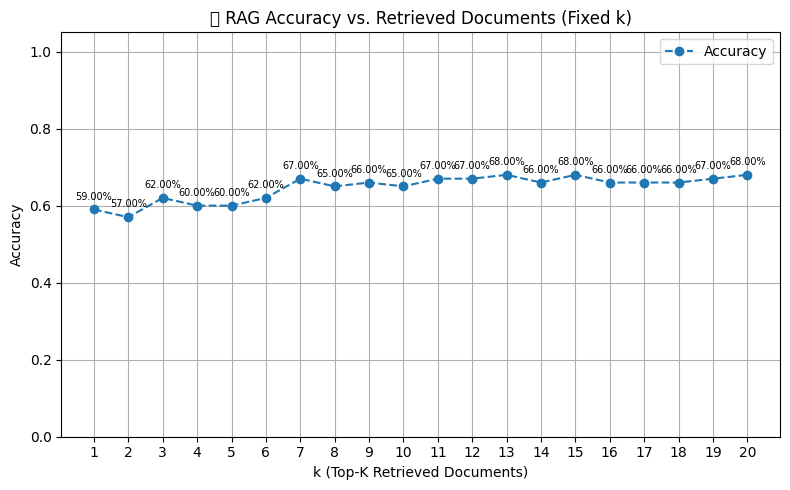

In [23]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_comparison(results: list):
    grouped = defaultdict(list)

    for res in results:
        for k_val, log in zip(res["ks"], res["logs"]):
            grouped[k_val].append(1 if log["status"] == "correct" else 0)

    sorted_ks = sorted(grouped.keys())
    accuracies = [np.mean(grouped[k]) for k in sorted_ks]

    plt.figure(figsize=(8, 5))
    plt.plot(sorted_ks, accuracies, marker='o', linestyle='--', label='Accuracy')

    for k, acc in zip(sorted_ks, accuracies):
        plt.text(
            k, acc + 0.02,
            f"{acc:.2%}",
            ha='center',
            fontsize=7,      
            va='bottom'      
        )

    plt.title("📊 RAG Accuracy vs. Retrieved Documents (Fixed k)")
    plt.xlabel("k (Top-K Retrieved Documents)")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.xticks(sorted_ks)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_accuracy_comparison(fixed_results)


/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_35911/1447656086.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


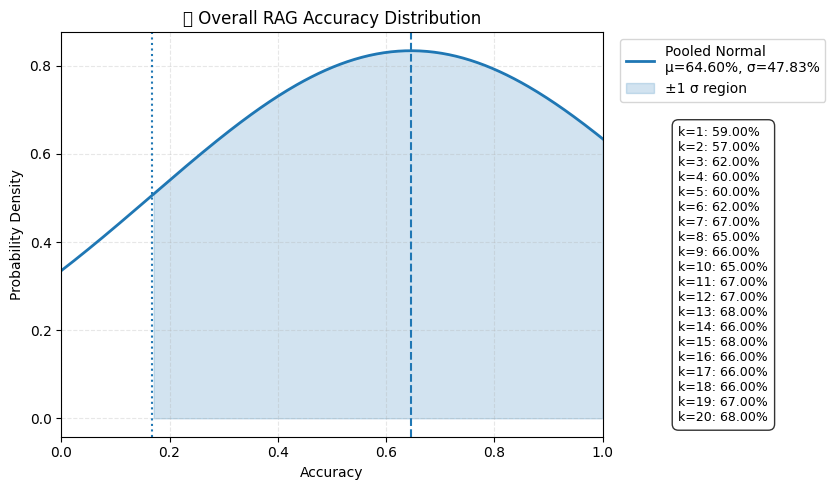

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import defaultdict

def plot_overall_accuracy_distribution(results: list, resolution: int = 300):
    """
    Pool all binary correctness flags across every k, fit a single Gaussian,
    plot its PDF, highlight μ±σ, and list each k’s accuracy on the side.
    """
    # 1) collect per-k and all flags
    per_k = defaultdict(list)
    all_flags = []
    for res in results:
        for k_val, log in zip(res["ks"], res["logs"]):
            flag = 1 if log["status"] == "correct" else 0
            per_k[k_val].append(flag)
            all_flags.append(flag)
    all_flags = np.array(all_flags)

    # 2) compute pooled μ and σ
    mu = all_flags.mean()
    sigma = all_flags.std(ddof=1)

    # 3) compute PDF
    x = np.linspace(0, 1, resolution)
    y = norm.pdf(x, loc=mu, scale=sigma)

    # 4) start plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, y, color='C0', lw=2, label=f"Pooled Normal\nμ={mu:.2%}, σ={sigma:.2%}")
    ax.fill_between(
        x, y,
        where=(x >= mu - sigma) & (x <= mu + sigma),
        color='C0', alpha=0.2,
        label="±1 σ region"
    )
    ax.axvline(mu, linestyle='--', color='C0')
    ax.axvline(mu - sigma, linestyle=':', color='C0')
    ax.axvline(mu + sigma, linestyle=':', color='C0')

    # 5) styling main axis
    ax.set_title("📊 Overall RAG Accuracy Distribution")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Probability Density")
    ax.set_xlim(0, 1)
    ax.grid(linestyle='--', alpha=0.3)

    # 6) build side‐box text of per‐k accuracies
    sorted_ks = sorted(per_k.keys())
    lines = []
    for k in sorted_ks:
        acc = np.mean(per_k[k])
        lines.append(f"k={k}: {acc:.2%}")
    text = "\n".join(lines)

    # place text box on the right
    ax.text(
        1.14, 0.4, text,
        transform=ax.transAxes,
        ha='left', va='center',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
    )

    # 7) legend for pooled curve
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


# Example usage:
plot_overall_accuracy_distribution(fixed_results)


## 📌 Key Takeaways from Fixed-k RAG Evaluation

### 1. **Accuracy Improves Early, Then Plateaus**  
#### - Accuracy climbs from **59% (k=1)** to **67% (k=7)**, then oscillates between **65–68%** through k=20.  
#### - The maximum fixed-k accuracy (~68%) occurs at k = 13, 15, and 20.

### 2. **Diminishing Returns Beyond k = 7**  
#### - Beyond **k = 7**, adding more documents yields at most a **1%–2%** gain in accuracy while having higher token and cost overhead.  
#### - From k = 7 → k = 20 cost grows linearly but accuracy only fluctuates within **1%–2%** of its peak.

### 3. **Non-Monotonic Behavior**  
#### - Peaks at k = 7, 13, 15, and 20 underscore the volatility of fixed‐k performance.

### 4. **Strong Case for Dynamic-k Retrieval**  
#### - Because accuracy flattens while costs continue to rise, **dynamic-k** methods—which adapt the number of retrieved docs per query 
#### offer a clear path to maintain or improve accuracy **and** control costs.


# 🧪 Approaches to Dynamically Determine `k` in Vector Similarity Search

### Choosing the right number of documents (`k`) to retrieve for a given query is crucial for balancing relevance, efficiency, and downstream model performance in RAG systems.

### Here we explore three statistically-motivated techniques for determining `k` dynamically based on the **distribution of similarity scores** between the query and candidate documents.

____

## 1. Benjamini–Hochberg Procedure (False Discovery Rate Control)

### 🔍 Overview
#### The **Benjamini–Hochberg (BH) procedure** is a statistical method for **controlling the False Discovery Rate (FDR)** — the expected proportion of false positives among the selected items. It is typically used in multiple hypothesis testing scenarios.

#### In the context of vector similarity search:
#### - Each document can be treated as a "hypothesis" (i.e., "Is this document relevant?").
#### - We compute **p-values** (or a proxy derived from similarity scores) for each document.
#### - BH controls the expected rate of false positives among the selected top-*k* documents.

### ⚙️ How it works
#### 1. Convert similarity scores into pseudo p-values (e.g., via ranking or null distribution assumptions).
#### 2. Sort these p-values in ascending order: $( p_1, p_2, ..., p_n )$
#### 3. For each p-value, check: $ p_i \leq \frac{i}{n} \cdot \alpha $ where $\alpha $ is the desired FDR (e.g., 0.05).
#### 4. Select the **largest `i`** that satisfies the inequality — set `k = i`.


In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def benjamini_hochberg(
    question_emb,
    doc_embs,
    null_distribution,
    alpha=0.05,
    max_k: int = 10
):
    n_docs = len(doc_embs)
    similarities = cosine_similarity([question_emb], doc_embs)[0]

    # Convert similarity to p-values based on the null distribution
    p_values = np.array([
        np.mean(null_distribution >= sim) for sim in similarities
    ])

    # Sort p-values and track original indices
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]

    k_selected = 0
    for i, p in enumerate(sorted_p_values, start=1):
        threshold = (i / n_docs) * alpha
        if p <= threshold:
            k_selected = i

    # Limit by max_k
    k_selected = min(k_selected, max_k)
    return max(k_selected,1)


____
## 2. Bonferroni Correction (Family-Wise Error Rate Control)

### 🔍 Overview
#### The **Bonferroni correction** is a conservative method to control the **Family-Wise Error Rate (FWER)** — the probability of making **any** false discovery.

#### It is stricter than BH and is often used when **false positives must be avoided at all costs**.

### ⚙️ How it works
#### 1. Convert similarity scores into pseudo p-values.
#### 2. Adjust the threshold using: $  \alpha' = \frac{\alpha}{n} $ where $ n $ is the total number of documents and $\alpha$ is the desired overall error rate (e.g., 0.05).
#### 3. Select all documents with $p_i \leq \alpha'$
#### 4. Set `k` as the number of documents that meet the criterion.



In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def bonferroni_correction(
    question_emb,
    doc_embs,
    null_distribution,
    alpha=0.05,
    max_k: int = 10
):
    similarities = cosine_similarity([question_emb], doc_embs)[0]
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_similarities = similarities[sorted_indices]

    alpha_prime = alpha / len(sorted_similarities)  # Bonferroni correction

    # Compute pseudo p-values: proportion of null scores ≥ observed
    pseudo_pvals = np.array([
        np.mean(null_distribution >= sim) for sim in sorted_similarities
    ])

    # Select all documents whose p-value ≤ corrected alpha
    valid_mask = pseudo_pvals <= alpha_prime
    k = int(np.sum(valid_mask))

    # Always return at least 1 document
    k = min(max(k, 1), max_k)

    return k


____
## 3. Higher Criticism

### 🔍 Overview
#### **Higher Criticism (HC)** is a powerful method for detecting **sparse and weak signals** in large-scale testing problems. It is especially effective when:
#### - Only a small fraction of documents are truly relevant.
#### - Their similarity scores are only **slightly stronger than noise**.

#### Originally proposed by Donoho & Jin (2008), HC finds an **optimal threshold** by balancing signal detection and noise suppression.

📄 [PNAS Article](https://www.pnas.org/doi/abs/10.1073/pnas.0807471105)

### ⚙️ How it works
#### 1. Convert similarity scores into z-scores or p-values under a null model.
#### 2. Compute the **Higher Criticism statistic** for each ordered p-value: $ HC(i) = \frac{\sqrt{n} \left( \frac{i}{n} - p_i \right)}{\sqrt{p_i (1 - p_i)}} $
#### 3. Find the **index `i` with the maximum HC value** → this index indicates the optimal threshold.
#### 4. Set `k = i`, selecting the top-`k` documents as relevant.


In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def higher_criticism(
    question_emb,
    doc_embs,
    null_distribution,
    alpha=0.05,
    max_k: int = 10
) -> int:
    # Step 1: Compute cosine similarities
    similarities = cosine_similarity([question_emb], doc_embs)[0]
    sorted_similarities = np.sort(similarities)[::-1]
    n = min(max_k, len(sorted_similarities))

    # Step 2: Convert similarities to empirical p-values using the null distribution
    p_values = np.array([
        (null_distribution >= sim).mean() for sim in sorted_similarities[:n]
    ])

    # Step 3: Clip extreme values for stability
    p_values = np.clip(p_values, 1e-10, 1 - 1e-10)

    # Step 4: Compute the HC statistic for each p-value
    i = np.arange(1, n + 1)
    expected = i / n
    hc_stats = np.sqrt(n) * (expected - p_values) / np.sqrt(p_values * (1 - p_values))

    # Step 5: Return the index with the maximum HC value
    best_k = int(np.argmax(hc_stats)) + 1
    return best_k


## Create the Null Distribution (using DailyDialog dataset)

### Load the DailyDialog dataset

In [28]:
from datasets import load_dataset
from typing import List

def load_unrelated_corpus_from_dailydialog() -> List[str]:
    """
    Load unrelated text samples from the DailyDialog dataset to build the null distribution.
    
    Returns:
        A list of utterances from the DailyDialog dataset.
    """
    dataset = load_dataset("daily_dialog")
    # Each sample has a 'dialog' key, which is a list of utterances
    corpus_texts = [utterance for d in dataset["train"] for utterance in d["dialog"] if utterance.strip()]
    return corpus_texts

daily_dialog_corpus = load_unrelated_corpus_from_dailydialog()

Using the latest cached version of the module from /Users/yarinshitrit/.cache/huggingface/modules/datasets_modules/datasets/daily_dialog/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd (last modified on Sat Jun 21 13:19:06 2025) since it couldn't be found locally at daily_dialog, or remotely on the Hugging Face Hub.


### Compute Real & Null Cosine Similarties

In [ ]:
# Compute the real similarities
real_sims = []
for idx in selected_indices:
    q_text = short_answer_dataset["question"][idx]
    q_emb  = np.array(get_embedding(q_text))
    # compute cosine similarity of this question to every doc in the collection
    sims   = cosine_similarity(q_emb.reshape(1, -1), np.array(hotpot_embeddings))[0]
    real_sims.extend(sims)

real_sims = np.array(real_sims)


In [29]:
def generate_null_distribution_against_hotpotqa(
    unrelated_questions: List[str],
    hotpot_embeddings: List[List[float]],
    n_trials: int = 100,
    k: int = 20
) -> np.ndarray:
    null_scores = []
    for _ in range(n_trials):
        question = np.random.choice(unrelated_questions)
        q_emb = get_embedding(question)

        # Compare each question to real HotpotQA documents
        sims = cosine_similarity([q_emb], hotpot_embeddings)[0]
        top_k_sims = np.sort(sims)[::-1][:k]

        null_scores.extend(top_k_sims)
    return np.array(null_scores)

null_distribution = generate_null_distribution_against_hotpotqa(daily_dialog_corpus, hotpot_embeddings)


## Null Distrubution Cosine Similarities vs Real Cosine Similarities

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions_overlay(
    dist1: np.ndarray,
    dist2: np.ndarray,
    labels: tuple[str, str] = ("Distribution 1", "Distribution 2"),
    bins: int = 50
):
    """
    Overlay two histograms on the same axes:
      • dist1 with label labels[0]
      • dist2 with label labels[1]

    Args:
        dist1 (np.ndarray): First array of values to histogram.
        dist2 (np.ndarray): Second array of values to histogram.
        labels (tuple[str, str]): Legend labels for the two histograms.
        bins (int): Number of bins to use.
    """
    # Compute common bin edges so the histograms align
    all_data = np.concatenate([dist1, dist2])
    bin_edges = np.linspace(all_data.min(), all_data.max(), bins + 1)

    plt.figure(figsize=(8, 5))
    plt.hist(
        dist1,
        bins=bin_edges,
        alpha=0.6,
        label=labels[0],
        edgecolor='black'
    )
    plt.hist(
        dist2,
        bins=bin_edges,
        alpha=0.6,
        label=labels[1],
        edgecolor='black'
    )
    plt.title(f"{labels[0]} vs. {labels[1]}")
    plt.xlabel("Cosine Similarity Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


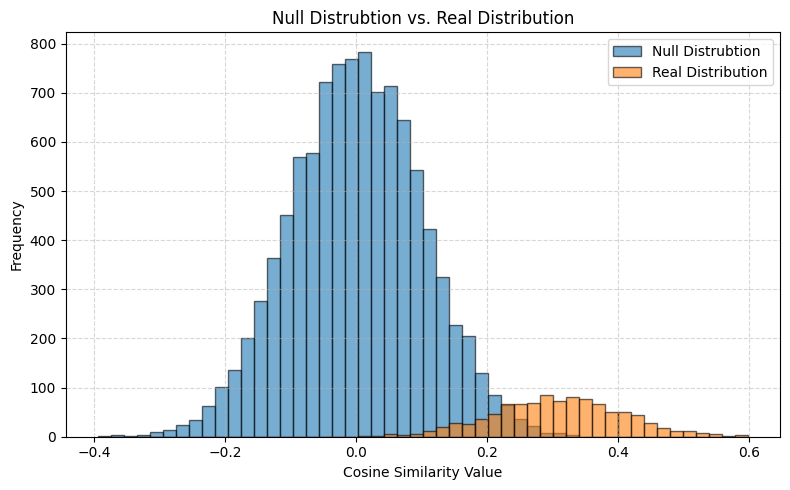

In [85]:
plot_distributions_overlay(null_distribution, real_sims, ("Null Distrubtion", "Real Distribution"))

### It's time to run our RAG Agent again, now with the dynamic k algorithms

In [ ]:
dynamic_results = []
alpha = 0.05

# Run dynamic-k evaluation
for dynamic_k_function in [higher_criticism, bonferroni_correction, benjamini_hochberg]:
    result = evaluate_rag_agent_parallel(
        dataset=short_answer_dataset,
        n_questions=n_questions,
        dynamic_k_function=dynamic_k_function,
        null_distribution=null_distribution,
        threshold=0.85,
        seed=seed,
        selected_indices=selected_indices,
        max_workers=10,
        alpha=alpha
    )
    result["method"] = dynamic_k_function.__name__
    result["alpha"] = alpha
    dynamic_results.append(result)


## 📊 Results & Takeaways

### Plot the results

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_35911/2613126518.py:98: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


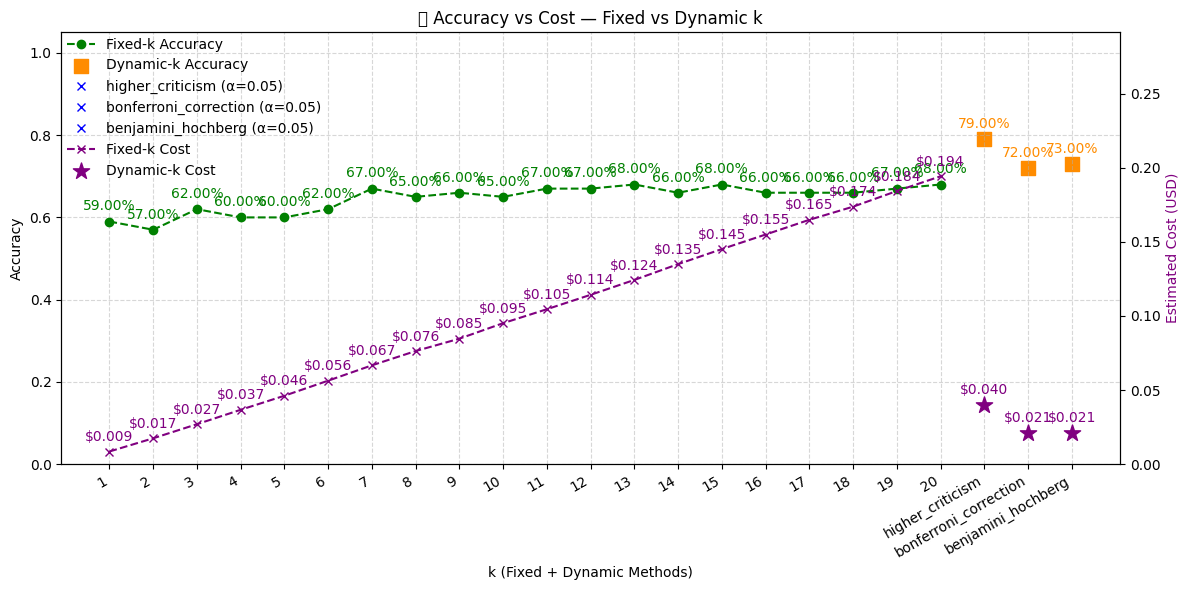

In [87]:
import matplotlib.pyplot as plt

def plot_tokens_cost_with_accuracy(
    fixed_k_results,
    dynamic_k_results,
    price_per_million_input: float = 1.100, #GPT o4-mini price
    price_per_million_output: float = 4.400 #GPT o4-mini price
):
    """
    Plot total tokens and estimated cost for fixed-k and dynamic-k runs,
    showing accuracy and cost above each point, using only input/output pricing.

    Args:
        fixed_k_results (list): Results for fixed k runs.
        dynamic_k_results (list): Results for dynamic k runs (each with 'method', 'alpha', 'logs', 'accuracy').
        price_per_million_input (float): $ per 1M input tokens.
        price_per_million_output (float): $ per 1M output tokens.
    """
    # per-token costs
    cost_in  = price_per_million_input  / 1_000_000
    cost_out = price_per_million_output / 1_000_000

    # Fixed-k stats
    fixed_ks, fixed_tokens_in, fixed_tokens_out, fixed_costs, fixed_accs = [], [], [], [], []
    for res in fixed_k_results:
        toks_in  = sum(len(doc["content"].split()) for log in res["logs"] for doc in log["retrieved_docs"])
        toks_out = sum(len(res["logs"][i]["prediction"].split()) for i in range(len(res["logs"])))
        cost = toks_in * cost_in + toks_out * cost_out

        fixed_ks.append(res["used_k"])
        fixed_tokens_in .append(toks_in)
        fixed_tokens_out.append(toks_out)
        fixed_costs.append(cost)
        fixed_accs.append(res["accuracy"])

    # Dynamic-k stats
    base = max(fixed_ks)
    dynamic_xs, dyn_tokens_in, dyn_tokens_out, dyn_costs, dyn_accs = [], [], [], [], []
    dyn_handles = []
    for i, res in enumerate(dynamic_k_results):
        x = base + 1 + i
        toks_in  = sum(len(doc["content"].split()) for log in res["logs"] for doc in log["retrieved_docs"])
        toks_out = sum(len(log["prediction"].split()) for log in res["logs"])
        cost = toks_in * cost_in + toks_out * cost_out

        dynamic_xs.append(x)
        dyn_tokens_in .append(toks_in)
        dyn_tokens_out.append(toks_out)
        dyn_costs.append(cost)
        dyn_accs.append(res["accuracy"])

        handle = plt.Line2D([], [], marker='x', color='blue', linestyle='',
                            label=f"{res['method']} (α={res.get('alpha',0.05):.2f})")
        dyn_handles.append(handle)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("k (Fixed + Dynamic Methods)")
    ax1.set_ylabel("Accuracy", color="black")

    # Accuracy curves
    ax1.plot(fixed_ks, fixed_accs, 'o--', color='green', label="Fixed-k Accuracy")
    ax1.scatter(dynamic_xs, dyn_accs, marker='s', color='darkorange', s=100, label="Dynamic-k Accuracy")
    for x, acc in zip(fixed_ks, fixed_accs):
        ax1.text(x, acc+0.02, f"{acc:.2%}", ha='center', va='bottom', color='green')
    for x, acc in zip(dynamic_xs, dyn_accs):
        ax1.text(x, acc+0.02, f"{acc:.2%}", ha='center', va='bottom', color='darkorange')

    ax1.set_ylim(0, 1.05)

    # Cost axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Estimated Cost (USD)", color="purple")
    ax2.plot(fixed_ks, fixed_costs, 'x--', color='purple', label="Fixed-k Cost")
    ax2.scatter(dynamic_xs, dyn_costs, marker='*', color='purple', s=150, label="Dynamic-k Cost")
    for x, c in zip(fixed_ks, fixed_costs):
        ax2.text(x, c+0.005, f"${c:.3f}", ha='center', va='bottom', color='purple')
    for x, c in zip(dynamic_xs, dyn_costs):
        ax2.text(x, c+0.005, f"${c:.3f}", ha='center', va='bottom', color='purple')

    max_cost = max(fixed_costs + dyn_costs)
    ax2.set_ylim(0, max_cost * 1.5)

    # X-ticks & legend
    xticks = fixed_ks + dynamic_xs
    xlabels = [str(k) for k in fixed_ks] + [res['method'] for res in dynamic_k_results]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels, rotation=30, ha='right')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + dyn_handles + handles2
    labels  = labels1  + [h.get_label() for h in dyn_handles] + labels2

    fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.05, 0.95), frameon=False)
    ax1.grid(True, linestyle='--', alpha=0.5)
    plt.title("📊 Accuracy vs Cost — Fixed vs Dynamic k")
    plt.tight_layout()
    plt.show()

plot_tokens_cost_with_accuracy(fixed_results, dynamic_results)


| **Method**                     | **Accuracy** | **Cost (USD)** |
| ------------------------------ | ------------ | -------------- |
| Fixed k = 1                    | 59%          | $0.009         |
| Fixed k = 2                    | 57%          | $0.017         |
| Fixed k = 3                    | 62%          | $0.027         |
| Fixed k = 4                    | 60%          | $0.037         |
| Fixed k = 5                    | 60%          | $0.046         |
| Fixed k = 6                    | 62%          | $0.056         |
| Fixed k = 7                    | 67%          | $0.076         |
| Fixed k = 8                    | 65%          | $0.085         |
| Fixed k = 9                    | 66%          | $0.095         |
| Fixed k = 10                   | 65%          | $0.105         |
| Fixed k = 11                   | 67%          | $0.114         |
| Fixed k = 12                   | 67%          | $0.124         |
| Fixed k = 13                   | 68%          | $0.135         |
| Fixed k = 14                   | 66%          | $0.145         |
| Fixed k = 15                   | 68%          | $0.155         |
| Fixed k = 16                   | 66%          | $0.165         |
| Fixed k = 17                   | 66%          | $0.174         |
| Fixed k = 18                   | 66%          | $0.184         |
| Fixed k = 19                   | 67%          | $0.190         |
| Fixed k = 20                   | 68%          | $0.199         |
| **Higher Criticism (α = 0.05)**     | **79%**          | **$0.040**         |
| Bonferroni Correction (α = 0.05)| 72%          | $0.021         |
| Benjamini–Hochberg (α = 0.05)   | 73%          | $0.021         |

## 💼 Strategic Takeaways

### ✅ Dynamic‐k Yields Major Gains
- **Higher Criticism** hits **79% accuracy** at just **\$0.04**, versus **68%** at **\$0.199** for the best fixed-k (k = 20)—a nearly **5× cost reduction** for an 11-point accuracy boost.  
- **Benjamini–Hochberg** delivers **73%** at **\$0.021**, outperforming Fixed k = 7 (67% @ \$0.076) with **+6% accuracy** at **~70% lower cost**.

---

### 📉 Fixed-k Shows Diminishing Returns
- Beyond **k = 7**, accuracy flattens around **66–68%** while cost climbs from **\$0.076 → \$0.199** (×2.6).  
- From **k = 10 → k = 20**, cost nearly **doubles** with **0–3%** net accuracy gain.

---

### 💸 Cost-Efficiency Favors Dynamic Selection
- **Benjamini–Hochberg** achieves **~34.8% accuracy per dollar** versus **8.8%** for Fixed k = 7.  
- **Higher Criticism** delivers **~19.8% accuracy per dollar**, nearly **2.3×** better than the best fixed-k. 

---

### 🔍 Operational Insight
- Adaptive retrieval **requests extra docs only when needed**, cutting wasted tokens.  
- Dynamic-k docuemnt retrieval is ideal for production RAG pipelines
